# 锚框

一类目标检测算法是通过锚框检测

- 提出多个称为锚框的边缘框
- 预测每一个锚框之中是否含有关注的物体
- 存在则预测真实边缘框的偏移

### 交并比

通过交并比 IoU 来计算两个锚框的相似度

- 0 表示无重叠，1表示重合


$$J(A,B)=\frac{|A\cap B|}{|A\cup B|}$$


### 赋予锚框标号

- 每一个锚框是一个训练样本
- 锚框要么表示一个背景，要么关联一个真实的边缘框
- 使用大量锚框代表着存在大量的负类样本


### 使用非极大值抑制(NMS)输出

- 每一个锚框预测一个边缘框
- NMS可以合并相似的预测
    - 选择非背景类的最大预测值
    - 去掉其他合并比大于$\theta$的框，表示已经选中
    - 重复知道所有预测要么被选中，要么被去掉

**Conclusion**

- 锚框目标检测
- 生产大量锚框，赋予标号，每个锚框作为一个样本训练
- 使用NMS除去

> 锚框的引入使得复杂度飙升

In [1]:
%matplotlib inline
import torch
import os
import numpy as np
from PIL import Image
from d2l import torch as d2l
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib_inline import backend_inline
torch.set_printoptions(2) # 更改打印精度

锚框的生产：

以每一个**像素为中心**生成：$宽度：w\cdot \sqrt{s\cdot r}和高度：\frac{h}{\sqrt{s\cdot r}} \qquad w,h 输入图片高宽，s锚框占图片的百分比，r锚框的高宽比$

1. 取5个s，5个r，25个组合
2. $(s_1, r_1), (s_1, r_2), \cdots ,(s_1, r_n), (s_2, r_1), (s_3, r_1), \cdots ,(s_n, r_1)$ 九个组合

In [2]:
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    num_boxes_per_pixel = num_sizes + num_ratios - 1
    size_tensor = torch.tensor(sizes, device=device)
    ratios_tensor = torch.tensor(ratios, device=device)

    offset_h, offset_w = 0.5, 0.5
    steps_h, steps_w = 1.0 / in_height, 1.0 / in_width

    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)  # 生成网格
    shift_y, shift_x = shift_y.reshape([-1]), shift_x.reshape(-1)  # 变成一行

    w = torch.cat((torch.sqrt(size_tensor) * torch.sqrt(ratios_tensor[0]),
                   torch.sqrt(size_tensor[0]) * torch.sqrt(ratios_tensor[1:]))) \
        * in_height / in_width
    h = torch.cat((torch.sqrt(size_tensor) / torch.sqrt(ratios_tensor[0]),
                   torch.sqrt(size_tensor[0]) / torch.sqrt(ratios_tensor[1:])))

    auchor_manipulartions = torch.stack(
        (-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(num_boxes_per_pixel, dim=0)
    out = out_grid + auchor_manipulartions
    return out.unsqueeze(0)

In [3]:
img = np.array(Image.open(os.path.join('.', 'img', 'catdog.jpg')))
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape # 给出 h * w * (2 + 3 - 1) 个锚框

561 728


torch.Size([1, 2042040, 4])

In [4]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 1, :]

tensor([0.07, 0.09, 0.62, 0.80])

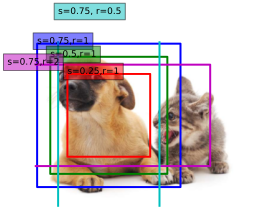

In [5]:
""" 绘制锚框 """
def bbox_to_rect(axes, bbox, color, text):
    axes.add_patch(
        plt.Rectangle(
            xy = (bbox[0], bbox[1]),
            width = bbox[2] - bbox[0],
            height = bbox[3] - bbox[1],
            fill = False,
            edgecolor = color,
            linewidth = 2
        )
    )
    axes.text(bbox[0], bbox[1], text,
             bbox = {'facecolor':color, 'alpha':0.5}, fontsize=9)

def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj,default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
        
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)] # 不同的框不同的颜色
        if labels and len(labels) > i:
            bbox_to_rect(axes, bbox.detach().numpy(), color, labels[i])
        else:
            bbox_to_rect(axes, bbox.detach().numpy(), color, None)
            

backend_inline.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = (5, 3)
plt.imshow(img)
plt.axis('off')
axes=plt.gca()
bbox_scale = torch.tensor([w, h, w, h])
show_bboxes(
    axes, boxes[250, 250, :, :] * bbox_scale,
    ['s=0.75,r=1', 's=0.5,r=1', 's=0.25,r=1',
     's=0.75,r=2', 's=0.75, r=0.5']
)

In [6]:
""" 交并比计算 """
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比。"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [7]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框。"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = box_iou(anchors, ground_truth)
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

偏移量计算：
A,B的中心量$(x_a, y_a)$和$(x_b, y_b)$，宽度为$w_a$和$w_b$，高度$h_a$和$h_b$，则A的偏移量：

$$\left( 
\frac{\frac{x_b-x_a}{w_a}-\mu_x}{\sigma_x},
\frac{\frac{y_b-y_a}{h_a}-\mu_y}{\sigma_y},
\frac{\log\frac{w_b}{w_a}-\mu_w}{\sigma_w},
\frac{\log\frac{h_b}{h_a}-\mu_h}{\sigma_h},
\right)$$

变化偏移量的值，利于网络学习

In [8]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换。"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [9]:
""" 标记锚点的类和偏移量 """
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框。"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors,
                                                 device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

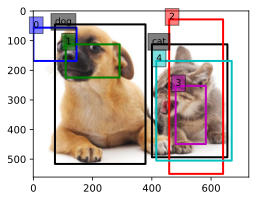

In [10]:
# 真实边框和锚框
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [11]:
""" 标注偏移量 """
labels = multibox_target(anchors.unsqueeze(dim=0),ground_truth.unsqueeze(dim=0))

In [12]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框。"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [13]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序。"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [14]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框。"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat(
            (class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [15]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,
                          [0.9, 0.8, 0.7, 0.1],
                          [0.1, 0.2, 0.3, 0.9]])

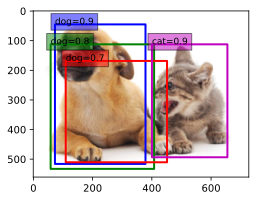

In [16]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

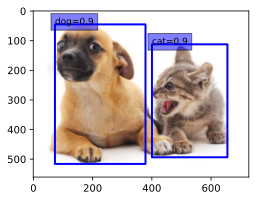

In [17]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0), nms_threshold=0.5)
fig = d2l.plt.imshow(img)
# 返回NMS抑制的输出
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)